# Лабораторная работа №3

## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

## Цель рабораторной работы: изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

Для выполненя данной лабораторной работы был взят датасет (Melbourne Housing Snapshot).


### Подготовка датафреймов
Импорт библиотек

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

In [86]:
data = pd.read_csv('melb_data.csv')
data.shape

(13580, 20)

In [87]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,0,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,0,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,0,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,0,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,0,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,Northern Metropolitan,4019.0


In [88]:
data.dtypes

Suburb            object
Address           object
Rooms              int64
Type               int64
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

In [89]:
data.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

Есть пропуски в данных, избавимся от них.

In [90]:
num_cols = []
for column in data.columns:
    temp_null_count = data[data[column].isnull()].shape[0]
    dt = str(data[column].dtype)

    if temp_null_count > 0 and (dt == 'float64' or dt == 'int64'):
        num_cols.append(column)
        temp_percent = round((temp_null_count/ data.shape[0]) * 100.0, 2)
        print('Столбец: {}. Тип данных: {}. Кол-во пустых значений: {}, {}%'.format(column, dt, temp_null_count, temp_percent))

Столбец: Car. Тип данных: float64. Кол-во пустых значений: 62, 0.46%
Столбец: BuildingArea. Тип данных: float64. Кол-во пустых значений: 6450, 47.5%
Столбец: YearBuilt. Тип данных: float64. Кол-во пустых значений: 5375, 39.58%


In [91]:
def impute_dataframe(df, col, strategy_name) -> pd.DataFrame:
    """
    Функия для заполнения пропусков в столбце датафрейма

    :param df: Датафрейм
    :param col: Столбец, в которой надо заполнить пропуски
    :param strategy_name: Стратегия импьютации
    :return: Датафрейм с заполнненой колонкой
    """
    imp = SimpleImputer(strategy=strategy_name)

    data_imputed = imp.fit_transform(df[[col]])
    df[[col]] = data_imputed

    return df

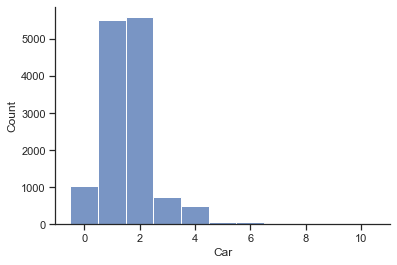

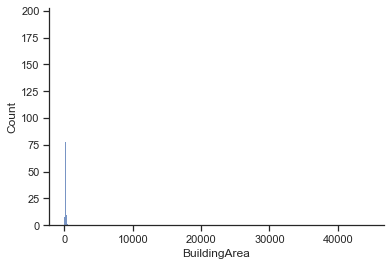

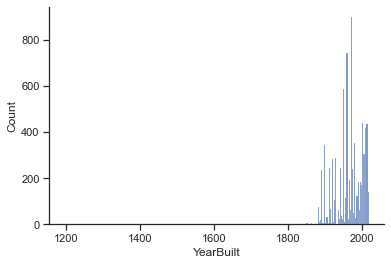

In [92]:
data_num = data[num_cols]

# Гистограмма по признакам
for column in data_num:
    if column == 'Car':
        sns.histplot(data[column], discrete=True)
    else:
        sns.histplot(data[column], binwidth=3, bins=75)
    sns.despine()
    plt.show()

In [93]:
data_comp = impute_dataframe(data, 'Car', 'median')
data_comp = impute_dataframe(data_comp, 'BuildingArea', 'most_frequent')
data_comp = impute_dataframe(data_comp, 'YearBuilt', 'most_frequent')

data_comp.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

Выберем Type как целевой признак. Отберем доп. параметры:

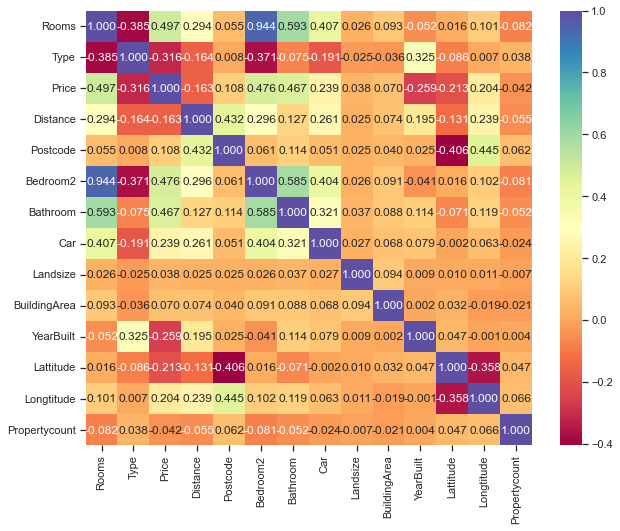

In [94]:
plt.figure(figsize=(10,8))
sns.heatmap(data=data_comp.corr(), annot=True, fmt='.3f', cmap='Spectral')
plt.show()

In [95]:
data_new = pd.DataFrame(data_comp.take([2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19], 1), columns=data_comp.columns.take([2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]))

data_new.head()

,Rooms,Type,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2,0,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,120.0,1970.0,-37.7996,144.9984,4019.0
1,2,0,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
2,3,0,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0
3,3,0,850000.0,2.5,3067.0,3.0,2.0,1.0,94.0,120.0,1970.0,-37.7969,144.9969,4019.0
4,4,0,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0


In [96]:
data_target = pd.DataFrame(data_new.take([1], 1), columns=data_new.columns.take([1]))
data_target.head()

,Type
0,0
1,0
2,0
3,0
4,0


In [97]:
data_data = pd.DataFrame(data_new.take([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 1), columns=data_new.columns.take([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]))
data_data.head()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,120.0,1970.0,-37.7996,144.9984,4019.0
1,2,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
2,3,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0
3,3,850000.0,2.5,3067.0,3.0,2.0,1.0,94.0,120.0,1970.0,-37.7969,144.9969,4019.0
4,4,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0


## Разделение выборки на обучающую и тестовую

In [98]:
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(
    data_data, data_target, test_size=0.5, random_state=1)

In [123]:
data_y_train = np.ravel(data_y_train)
data_y_test = np.ravel(data_y_test)

In [124]:
data_X_test.shape, data_y_test.shape

((6790, 13), (6790,))

In [125]:
data_X_train.shape, data_y_train.shape

((6790, 13), (6790,))

Проверим, чтобы в обоих моделях сохранились все уникальные значения типов.

In [126]:
np.unique(data_y_train)

array([0, 1, 2], dtype=int64)

In [127]:
np.unique(data_y_test)

array([0, 1, 2], dtype=int64)

### Построим базовые модели на основе метода ближайших соседей

In [182]:
cl1_1 = KNeighborsClassifier(n_neighbors=2)
cl1_1.fit(data_X_train, data_y_train)
target1_1 = cl1_1.predict(data_X_test)
len(target1_1), target1_1

(6790, array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [129]:
cl1_2 = KNeighborsClassifier(n_neighbors=10)
cl1_2.fit(data_X_train, data_y_train)
target1_2 = cl1_2.predict(data_X_test)
len(target1_2), target1_2

(6790, array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

## Метрики качества классификации

## Accuracy

Метрика вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов.

2 ближайших соседа:

In [130]:
accuracy_score(data_y_test, target1_1)

0.7419734904270987

10 ближайших соседей

In [131]:
accuracy_score(data_y_test, target1_2)

0.7649484536082474

In [132]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> dict[int, float]:
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    classes = np.unique(y_true)
    res = dict()
    for c in classes:
        temp_data_flt = df[df['t']==c]
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        res[c] = temp_acc
    return res
def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [146]:
# 2 ближайших соседа
print_accuracy_score_for_classes(data_y_test, target1_1)

Метка 	 Accuracy
0 	 0.932881643023502
1 	 0.4076517150395778
2 	 0.025408348457350273


In [147]:
# 10 ближайших соседей
print_accuracy_score_for_classes(data_y_test, target1_2)

Метка 	 Accuracy
0 	 0.9231420707177641
1 	 0.5488126649076517
2 	 0.003629764065335753


In [148]:
confusion_matrix(data_y_test, target1_1, labels=[0, 1, 2])

array([[4406,  275,   42],
       [ 879,  618,   19],
       [ 448,   89,   14]], dtype=int64)

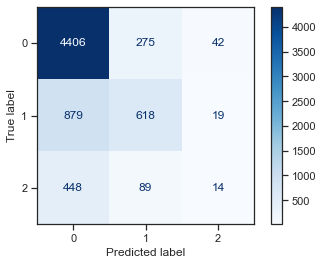

In [149]:
plot_confusion_matrix(cl1_1, data_X_test, data_y_test, 
                      display_labels=['0','1','2'], cmap=plt.cm.Blues)

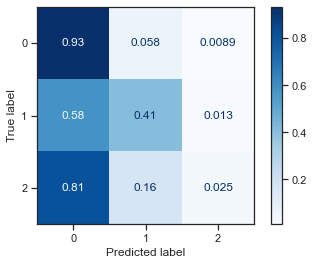

In [150]:
plot_confusion_matrix(cl1_1, data_X_test, data_y_test, 
                      display_labels=['0','1','2'], 
                      cmap=plt.cm.Blues, normalize='true')

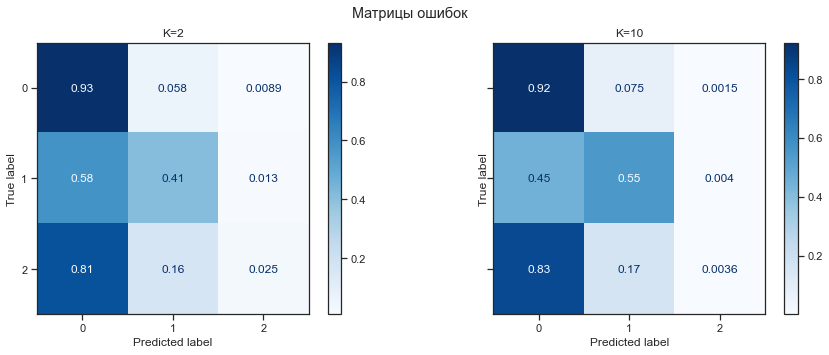

In [151]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))

plot_confusion_matrix(cl1_1, data_X_test, data_y_test, 
                      display_labels=['0','1','2'], 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[0])

plot_confusion_matrix(cl1_2, data_X_test, data_y_test, 
                      display_labels=['0','1','2'], 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[1])

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K=2')
ax[1].title.set_text('K=10')

## Precision и F-мера

### Precision

In [152]:
# Параметры TP, TN, FP, FN считаются как сумма по всем классам
precision_score(data_y_test, target1_1, average='micro')

0.7419734904270987

In [153]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется среднее значение, дисбаланс классов не учитывается.
precision_score(data_y_test, target1_1, average='macro')

0.5281758743847775

In [154]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется средневзвешенное значение, дисбаланс классов учитывается 
# в виде веса классов (вес - количество истинных значений каждого класса).
precision_score(data_y_test, target1_1, average='weighted')

0.6902350586656634

### F-мера

In [155]:
f1_score(data_y_test, target1_1, average='micro')

0.7419734904270987

In [156]:
f1_score(data_y_test, target1_1, average='macro')

0.4607646575936202

In [157]:
f1_score(data_y_test, target1_1, average='weighted')

0.700317696095943

Функция classification_report позволяет выводить значения точности, полноты и F-меры для всех классов выборки.

In [158]:
classification_report(data_y_test, target1_1, 
                      target_names=['0','1','2'], output_dict=True)

{'0': {'precision': 0.76853305424734,
  'recall': 0.932881643023502,
  'f1-score': 0.8427697016067329,
  'support': 4723},
 '1': {'precision': 0.6293279022403259,
  'recall': 0.4076517150395778,
  'f1-score': 0.4947958366693354,
  'support': 1516},
 '2': {'precision': 0.18666666666666668,
  'recall': 0.025408348457350273,
  'f1-score': 0.04472843450479234,
  'support': 551},
 'accuracy': 0.7419734904270987,
 'macro avg': {'precision': 0.5281758743847775,
  'recall': 0.45531390217347667,
  'f1-score': 0.4607646575936202,
  'support': 6790},
 'weighted avg': {'precision': 0.6902350586656634,
  'recall': 0.7419734904270987,
  'f1-score': 0.700317696095943,
  'support': 6790}}

## Оптимизация гиперпараметров

### Grid Search (решетчатый поиск)

In [159]:
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [160]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(data_X_train, data_y_train)


Wall time: 3.32 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             scoring='accuracy')

In [161]:
clf_gs.cv_results_

{'mean_fit_time': array([0.01655622, 0.01537189, 0.01535854, 0.01754708, 0.01629815,
        0.01716003, 0.01835046, 0.01735306, 0.01686869, 0.01435661]),
 'std_fit_time': array([0.00149038, 0.00162208, 0.00136463, 0.00175869, 0.00115849,
        0.00222414, 0.00173956, 0.00240963, 0.00148746, 0.00049311]),
 'mean_score_time': array([0.04169302, 0.04189148, 0.04378438, 0.04515057, 0.05205088,
        0.05496502, 0.05386777, 0.05221157, 0.05255427, 0.05229406]),
 'std_score_time': array([0.00131025, 0.00267012, 0.00221231, 0.00198409, 0.00263179,
        0.00582389, 0.00575182, 0.00411129, 0.00115668, 0.00326683]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20},
  {'n_neighbors': 25},
  {'n_neig

In [162]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=40)

In [163]:
# Лучшее значение метрики
clf_gs.best_score_

0.7649484536082474

In [164]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 40}

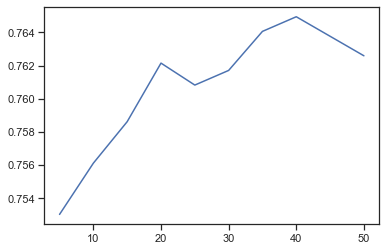

In [165]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

### Randomized Search (случайный поиск)

Используется в том случае когда полный решетчатый поиск работает слишком долго.

In [166]:
%%time
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_rs.fit(data_X_train, data_y_train)

Wall time: 3.31 s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
                   scoring='accuracy')

In [167]:
# В данном случае оба способа нашли одинаковое решение
clf_rs.best_score_, clf_rs.best_params_

(0.7649484536082474, {'n_neighbors': 40})

In [168]:
clf_gs.best_score_, clf_gs.best_params_

(0.7649484536082474, {'n_neighbors': 40})

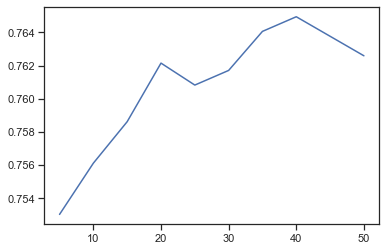

In [169]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_rs.cv_results_['mean_test_score'])

### Построение кривых обучения и валидации
### Построение кривых обучения - learning_curve
Строится зависимость метрики на обучающей выборке от размера выборки.

In [170]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\neytr\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

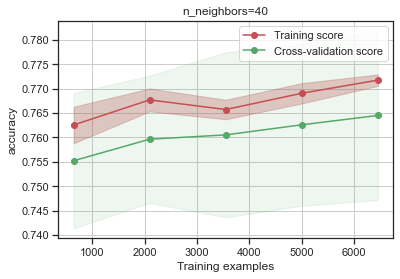

In [176]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=40), 'n_neighbors=40', 
                    data_X_train, data_y_train, cv=20)

<module 'matplotlib.pyplot' from 'C:\\Users\\neytr\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

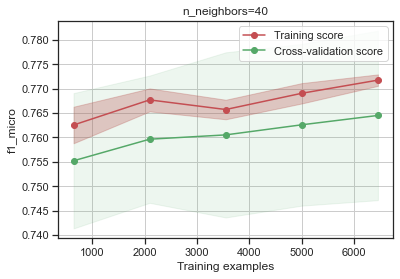

In [178]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=40), 'n_neighbors=40', 
                    data_X_train, data_y_train, cv=20, scoring='f1_micro')

<module 'matplotlib.pyplot' from 'C:\\Users\\neytr\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

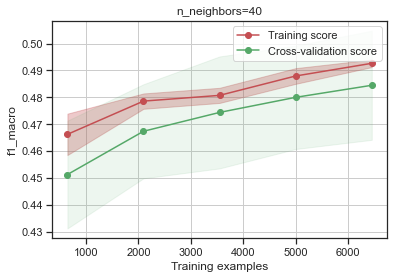

In [179]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=40), 'n_neighbors=40', 
                    data_X_train, data_y_train, cv=20, scoring='f1_macro')

## Построение кривой валидации - validation_curve

Строится зависимость метрики на тестовой выборке от одного из гиперпараметров.

In [180]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring='accuracy'):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\neytr\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

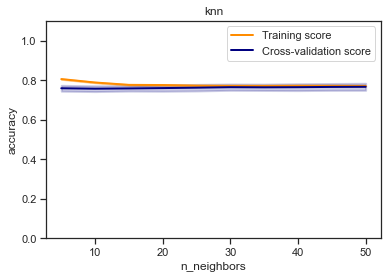

In [181]:
plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      data_X_train, data_y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=20, scoring="accuracy")